Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.3161 - val_loss: 0.2747
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2693 - val_loss: 0.2413
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2409 - val_loss: 0.2079
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2047 - val_loss: 0.1721
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1754 - val_loss: 0.1328
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1296 - val_loss: 0.0974
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1032 - val_loss: 0.1057
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1103 - val_loss: 0.1042
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1033 - val_loss: 0.0896
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0921 - val_loss: 0.0889
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0932 - val_loss: 0.0932
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0954 - val_loss: 0.0959
Epoch 13/20

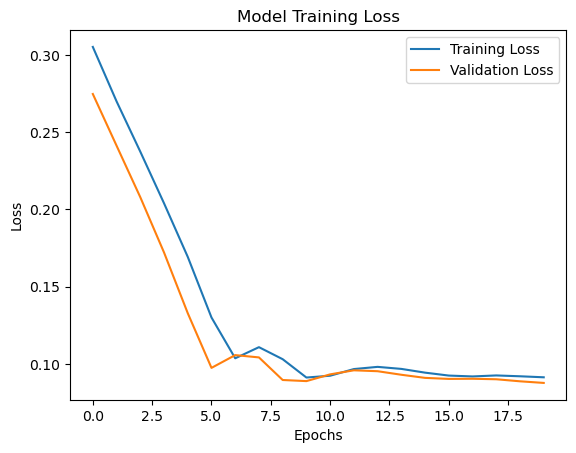

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and prepare data
data_path = 'data/main/sensor_data.csv'  # Update with the actual path
data = pd.read_csv(data_path)

# Assume 'CO' column contains CO concentrations
data['co_concentration'] = data['co_concentration'].values.astype(float)

# Normalize the CO data (0 to 1 scale)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['co_concentration']])

# Prepare data for LSTM model (predict next 6 hours)
def create_dataset(data, time_step=72, forecast_hours=6):
    X, y = [], []
    for i in range(len(data) - time_step - forecast_hours):
        X.append(data[i:(i + time_step), 0])
        y.append(data[(i + time_step):(i + time_step + forecast_hours), 0])
    return np.array(X), np.array(y)

# Prepare X and y for LSTM model
X, y = create_dataset(data_scaled)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=6))  # Output is 6 hours prediction

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict CO concentrations for the next 6 hours
predictions = model.predict(X_test)

# Reverse scaling for predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Display predicted values for the first test sample
print("Predicted CO concentrations for the next 6 hours:")
for i, prediction in enumerate(predictions[0]):
    print(f"Hour {i + 1}: {prediction:.2f} ppm")

# Fan control logic based on predicted CO concentrations
def control_fan(sensor_1_value, sensor_2_value):
    # Define CO concentration thresholds for fan control
    threshold_1 = 0.5  # Low threshold (ppm)
    threshold_2 = 1.0  # High threshold (ppm)
    
    # Initial fan settings
    fan_speed = 'OFF'
    fan_direction = 'NONE'
    
    # Control fan based on the sensor values
    if sensor_1_value > threshold_2 or sensor_2_value > threshold_2:
        fan_speed = 'HIGH'
        if sensor_1_value > sensor_2_value:
            fan_direction = 'TOWARDS SENSOR 1'
        else:
            fan_direction = 'TOWARDS SENSOR 2'
    elif sensor_1_value > threshold_1 or sensor_2_value > threshold_1:
        fan_speed = 'LOW'
        if sensor_1_value > sensor_2_value:
            fan_direction = 'TOWARDS SENSOR 1'
        else:
            fan_direction = 'TOWARDS SENSOR 2'
    else:
        fan_speed = 'OFF'
        fan_direction = 'NONE'
    
    # Output the fan control actions
    return fan_speed, fan_direction

# Example: Get predictions for the next 6 hours and control fan based on those predictions
for i in range(6):
    # Use predicted values as CO concentrations from the sensors
    sensor_1_value = predictions[0][i]
    sensor_2_value = predictions[0][i]  # Assuming both sensors have similar readings
    
    # Get the fan control decision based on the predicted CO levels
    fan_speed, fan_direction = control_fan(sensor_1_value, sensor_2_value)
    print(f"Predicted CO concentration for hour {i + 1}: {sensor_1_value:.2f} ppm")
    print(f"Fan Speed: {fan_speed}, Fan Direction: {fan_direction}")
    print()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
